# Sweep Explorer - Interactive Parameter Visualization

Interactive explorer for experimental sweep results. Map sweep parameters
(entry_max, label_max, dataset, summarizer, k) onto chart axes, facets,
color, and filters.

**Prerequisites:** Run `scripts/run_experimental_sweep.py` or `pca_kllmeans_sweep.ipynb`
to generate `experimental_sweep_*.pkl` files in the repo root.

In [1]:
# Install hvplot if needed (safe to re-run)
%pip install -q hvplot

import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import hvplot.pandas  # registers .hvplot accessor on DataFrames
import panel as pn

# Enable Panel widgets in notebook
pn.extension('tabulator', design='material', sizing_mode='stretch_width')

warnings.filterwarnings('ignore', category=FutureWarning)


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_sweep_dataframe(data_dir: str = "../experimental_results") -> pd.DataFrame:
    """
    Load all experimental_sweep_*.pkl files and flatten into one row per (file, k).

    Args:
        data_dir: Directory containing pickle files (default: ../experimental_results)

    Returns:
        DataFrame with sweep parameters and metrics as columns.
    """
    rows = []
    errors = []

    for pkl_path in sorted(Path(data_dir).glob("experimental_sweep_*.pkl")):
        try:
            with open(pkl_path, "rb") as f:
                data = pickle.load(f)
        except Exception as e:
            errors.append((pkl_path.name, str(e)))
            continue

        meta = data.get("metadata", {})
        result = data.get("result", {})
        by_k = result.get("by_k", {})

        for k_str, k_data in by_k.items():
            stab = k_data.get("stability") or {}
            
            # Handle StabilityMetrics dataclass instances vs plain dicts
            if hasattr(stab, "__dict__") and not isinstance(stab, dict):
                stab = stab.__dict__
            
            # Extract metrics from nested structure
            # Stability can be: {'silhouette': {'mean': x, 'std': y}, 'stability_ari': {...}, ...}
            # Or flat: {'silhouette_mean': x, 'silhouette_std': y, ...}
            def get_metric(metric_dict, name):
                """Extract metric from nested or flat structure"""
                if isinstance(metric_dict, dict):
                    if name in metric_dict:
                        return metric_dict[name]
                    # Check nested structure
                    for key in ['silhouette', 'stability_ari', 'dispersion', 'coverage', 'inertia']:
                        if key in metric_dict and isinstance(metric_dict[key], dict):
                            if 'mean' in name.lower() and 'mean' in metric_dict[key]:
                                if key in name:
                                    return metric_dict[key]['mean']
                            if 'std' in name.lower() and 'std' in metric_dict[key]:
                                if key in name:
                                    return metric_dict[key]['std']
                return None
            
            rows.append({
                "entry_max": meta.get("entry_max"),
                "dataset": meta.get("benchmark_source", data.get("dataset_name", "unknown")),
                "label_max": meta.get("label_max"),
                "summarizer": meta.get("summarizer", "unknown"),
                "k": int(k_str),
                # Handle both nested and flat structures
                "ari_mean": (stab.get('stability_ari', {}).get('mean') if isinstance(stab.get('stability_ari'), dict) 
                            else stab.get('stability_ari_mean')),
                "ari_std": (stab.get('stability_ari', {}).get('std') if isinstance(stab.get('stability_ari'), dict) 
                           else stab.get('stability_ari_std')),
                "silhouette_mean": (stab.get('silhouette', {}).get('mean') if isinstance(stab.get('silhouette'), dict) 
                                   else stab.get('silhouette_mean')),
                "silhouette_std": (stab.get('silhouette', {}).get('std') if isinstance(stab.get('silhouette'), dict) 
                                  else stab.get('silhouette_std')),
                "coverage_mean": (stab.get('coverage', {}).get('mean') if isinstance(stab.get('coverage'), dict) 
                                 else stab.get('coverage_mean')),
                "coverage_std": (stab.get('coverage', {}).get('std') if isinstance(stab.get('coverage'), dict) 
                                else stab.get('coverage_std')),
                "inertia_mean": (stab.get('dispersion', {}).get('mean') if isinstance(stab.get('dispersion'), dict) 
                                else stab.get('inertia_mean', stab.get('dispersion_mean'))),
                "inertia_std": (stab.get('dispersion', {}).get('std') if isinstance(stab.get('dispersion'), dict) 
                               else stab.get('inertia_std', stab.get('dispersion_std'))),
                "ari_vs_ground_truth": stab.get("ari_vs_ground_truth"),
                "objective": k_data.get("objective"),
                "actual_entry_count": meta.get("actual_entry_count"),
                "actual_label_count": meta.get("actual_label_count"),
                "source_file": pkl_path.name,
            })

    if errors:
        print(f"[WARN] Failed to load {len(errors)} file(s):")
        for name, err in errors[:5]:
            print(f"  {name}: {err}")

    df = pd.DataFrame(rows)
    
    # Convert None to NaN for numeric columns (fixes hvplot/numpy comparison errors)
    if not df.empty:
        numeric_cols = [
            'ari_mean', 'ari_std', 'silhouette_mean', 'silhouette_std',
            'coverage_mean', 'coverage_std', 'inertia_mean', 'inertia_std',
            'ari_vs_ground_truth', 'objective', 'actual_entry_count', 
            'actual_label_count', 'entry_max', 'label_max'
        ]
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Drop columns that are completely empty
        df = df.dropna(axis=1, how='all')
        
        print(f"[OK] Loaded {len(df)} rows from {df['source_file'].nunique()} pickle files.")
        print(f"     Datasets: {sorted(df['dataset'].unique())}")
        print(f"     Summarizers: {sorted(df['summarizer'].unique())}")
        print(f"     entry_max: {sorted(df['entry_max'].dropna().unique())}")
        print(f"     label_max: {sorted(df['label_max'].dropna().unique())}")
        print(f"     k range: {df['k'].min()} - {df['k'].max()}")
        print(f"     Available metric columns: {[c for c in df.columns if c in numeric_cols]}")
        print(f"     DataFrame shape: {df.shape}")
    else:
        print("[WARN] No pickle files found. Run sweep script first to generate data.")
    return df


df = load_sweep_dataframe()
print(f"\n[DEBUG] df.empty = {df.empty}")
print(f"[DEBUG] len(df) = {len(df)}")
df.head()

[OK] Loaded 3141 rows from 349 pickle files.
     Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia', 'yahoo_answers']
     Summarizers: ['None', 'gpt-4o', 'gpt-4o-mini', 'gpt-5-chat']
     entry_max: [np.int64(100), np.int64(200), np.int64(300), np.int64(400), np.int64(500)]
     label_max: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
     k range: 2 - 10
     Available metric columns: ['entry_max', 'label_max', 'ari_mean', 'ari_std', 'silhouette_mean', 'silhouette_std', 'coverage_mean', 'coverage_std', 'inertia_mean', 'inertia_std', 'objective', 'actual_entry_count', 'actual_label_count']
     DataFrame shape: (3141, 17)

[DEBUG] df.empty = False
[DEBUG] len(df) = 3141


,entry_max,dataset,label_max,summarizer,k,ari_mean,ari_std,silhouette_mean,silhouette_std,coverage_mean,coverage_std,inertia_mean,inertia_std,objective,actual_entry_count,actual_label_count,source_file
0,100,20newsgroups_10cat,1,gpt-4o,2,0.221651,0.234452,0.065419,0.004809,0.0000,0.000000,0.789241,0.006044,78.003882,100,1,experimental_sweep_entry100_20newsgroups_10cat...
1,100,20newsgroups_10cat,1,gpt-4o,3,0.273558,0.136619,0.061819,0.006334,0.0000,0.000000,0.721322,0.007871,71.174634,100,1,experimental_sweep_entry100_20newsgroups_10cat...
2,100,20newsgroups_10cat,1,gpt-4o,4,0.265482,0.095696,0.058911,0.009215,0.0005,0.002179,0.681253,0.011009,66.949057,100,1,experimental_sweep_entry100_20newsgroups_10cat...
3,100,20newsgroups_10cat,1,gpt-4o,5,0.208497,0.069513,0.050590,0.008673,0.0010,0.003000,0.657712,0.012150,64.152566,100,1,experimental_sweep_entry100_20newsgroups_10cat...
4,100,20newsgroups_10cat,1,gpt-4o,6,0.187624,0.062190,0.048295,0.008808,0.0010,0.003000,0.633295,0.010585,62.162543,100,1,experimental_sweep_entry100_20newsgroups_10cat...


## Data Filtering

Select specific parameter combinations to analyze:

In [3]:
if not df.empty:
    # Create filter widgets
    datasets = sorted(df['dataset'].unique())
    summarizers = sorted(df['summarizer'].unique())
    entry_maxes = sorted(df['entry_max'].dropna().unique())
    label_maxes = sorted(df['label_max'].dropna().unique())
    
    dataset_filter = pn.widgets.MultiChoice(
        name='Datasets', 
        options=datasets, 
        value=datasets[:3] if len(datasets) > 3 else datasets,
        solid=False
    )
    summarizer_filter = pn.widgets.MultiChoice(
        name='Summarizers', 
        options=summarizers, 
        value=summarizers,
        solid=False
    )
    entry_max_filter = pn.widgets.MultiChoice(
        name='Entry Max', 
        options=[int(x) for x in entry_maxes],
        value=[int(x) for x in entry_maxes[:2]] if len(entry_maxes) > 2 else [int(x) for x in entry_maxes],
        solid=False
    )
    label_max_filter = pn.widgets.MultiChoice(
        name='Label Max', 
        options=[int(x) for x in label_maxes],
        value=[int(x) for x in label_maxes[:3]] if len(label_maxes) > 3 else [int(x) for x in label_maxes],
        solid=False
    )
    
    # Function to apply filters
    @pn.depends(dataset_filter, summarizer_filter, entry_max_filter, label_max_filter)
    def get_filtered_df(datasets, summarizers, entry_maxes, label_maxes):
        filtered = df.copy()
        if datasets:
            filtered = filtered[filtered['dataset'].isin(datasets)]
        if summarizers:
            filtered = filtered[filtered['summarizer'].isin(summarizers)]
        if entry_maxes:
            filtered = filtered[filtered['entry_max'].isin(entry_maxes)]
        if label_maxes:
            filtered = filtered[filtered['label_max'].isin(label_maxes)]
        
        print(f"Filtered to {len(filtered)} rows (from {len(df)} total)")
        return filtered
    
    # Display filter controls
    filter_panel = pn.Column(
        "### Filter Data",
        pn.Row(dataset_filter, summarizer_filter),
        pn.Row(entry_max_filter, label_max_filter),
        pn.pane.Markdown("**Note:** Select values above, then run cells below to see filtered results."),
    )
    filter_panel
else:
    print("[WARN] No data to filter")

In [4]:
# Apply filters to create filtered dataframe
if not df.empty:
    df_filtered = get_filtered_df(
        dataset_filter.value,
        summarizer_filter.value, 
        entry_max_filter.value,
        label_max_filter.value
    )
    
    print(f"\nFiltered data summary:")
    print(f"  Datasets: {sorted(df_filtered['dataset'].unique())}")
    print(f"  Summarizers: {sorted(df_filtered['summarizer'].unique())}")
    print(f"  Entry max: {sorted(df_filtered['entry_max'].dropna().unique())}")
    print(f"  Label max: {sorted(df_filtered['label_max'].dropna().unique())}")
    print(f"  K range: {df_filtered['k'].min()} - {df_filtered['k'].max()}")
else:
    df_filtered = df

Filtered to 639 rows (from 3141 total)

Filtered data summary:
  Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia']
  Summarizers: ['None', 'gpt-4o', 'gpt-4o-mini', 'gpt-5-chat']
  Entry max: [np.int64(100), np.int64(200)]
  Label max: [np.int64(1), np.int64(2), np.int64(3)]
  K range: 2 - 10


## Interactive Explorer

The explorer below lets you change:
- **Kind**: Chart type (line, scatter, bar, box, etc.)
- **X / Y**: Which column on each axis
- **by**: Color grouping
- **groupby**: Creates a widget (slider/dropdown) to step through values
- Additional options in the sidebar (aggregation, faceting, etc.)

If `hvDataFrameExplorer` is not available in your hvplot version, Cell 5 provides
a manual widget-based fallback.

In [5]:
# Try the built-in explorer first - using FILTERED data
try:
    from hvplot.ui import hvDataFrameExplorer
except ImportError:
    try:
        from hvplot.explorer import hvDataFrameExplorer
    except ImportError:
        hvDataFrameExplorer = None

print(f"[DEBUG] hvDataFrameExplorer available: {hvDataFrameExplorer is not None}")
print(f"[DEBUG] df_filtered.empty: {df_filtered.empty}")

if hvDataFrameExplorer is not None and not df_filtered.empty:
    # Find first metric column (exclude experimental parameters)
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns
    # Prioritize actual metrics over experimental parameters
    metric_priority = ['ari_mean', 'silhouette_mean', 'coverage_mean', 'inertia_mean']
    metadata_cols = ['k', 'entry_max', 'label_max', 'actual_entry_count', 'actual_label_count']
    
    available_metrics = [col for col in numeric_cols if df_filtered[col].notna().any() and col not in metadata_cols]
    
    # Try to use a priority metric first
    default_y = None
    for metric in metric_priority:
        if metric in available_metrics:
            default_y = metric
            break
    
    # Fall back to first available if no priority metric found
    if default_y is None and available_metrics:
        default_y = available_metrics[0]
    
    if default_y:
        print(f"[INFO] Using '{default_y}' as default y-axis. Available metrics: {available_metrics}")
        print(f"[DEBUG] Creating explorer with {len(df_filtered)} rows...")
        
        try:
            explorer = hvDataFrameExplorer(
                df_filtered,
                kind="line",
                x="k",
                y=default_y,
                by=["summarizer"],
            )
            print(f"[DEBUG] Explorer created successfully: {type(explorer)}")
            print(f"[DEBUG] Displaying explorer...")
            display(explorer)  # Explicit display
        except Exception as e:
            print(f"[ERROR] Failed to create/display explorer: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("[WARN] No metric columns with data available for plotting")
else:
    if df_filtered.empty:
        print("[WARN] No data after filtering. Adjust filters above.")
    else:
        print("[INFO] hvDataFrameExplorer not available. Use the manual explorer in the next cell.")

[DEBUG] hvDataFrameExplorer available: True
[DEBUG] df_filtered.empty: False
[INFO] Using 'ari_mean' as default y-axis. Available metrics: ['ari_mean', 'ari_std', 'silhouette_mean', 'silhouette_std', 'coverage_mean', 'coverage_std', 'inertia_mean', 'inertia_std', 'objective']
[DEBUG] Creating explorer with 639 rows...
[DEBUG] Explorer created successfully: <class 'hvplot.ui.hvDataFrameExplorer'>
[DEBUG] Displaying explorer...


hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced00302', opts={}), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes00296', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=['summarizer'], code="df.hvplot(\n    by=['summarizer'],\n    kind='line',\n    x='k',\n    y=['ari_mean'],\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping00297', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic00299', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='line', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels00298', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer00274', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations00300', rasterize=False, x_sampling=None, y_sampling=None), statusbar=StatusBar(live_update=True, name='StatusBar00289'), style=Style(alpha=1, explorer=..., name='Style00301'), x='k', y='ari_mean', y_multi=['ari_mean'], z=None)

In [6]:
# Manual explorer: Panel widgets + hvplot (works in any hvplot version)
# Run this cell if hvDataFrameExplorer is not available, or if you want more control.

if df.empty:
    print("[WARN] No data loaded.")
else:
    numeric_cols = list(df.select_dtypes(include="number").columns)
    categorical_cols = [c for c in df.columns if c not in numeric_cols]
    all_cols = numeric_cols + categorical_cols

    # --- Chart controls ---
    kind_select = pn.widgets.Select(name="Chart Type", options=["line", "scatter", "bar", "box", "area", "hist"], value="line", width=140)
    x_select = pn.widgets.Select(name="X Axis", options=numeric_cols, value="k", width=180)
    y_select = pn.widgets.Select(name="Y Axis", options=numeric_cols, value="ari_mean", width=180)
    by_select = pn.widgets.Select(name="Color (by)", options=["None"] + all_cols, value="summarizer", width=180)
    facet_col = pn.widgets.Select(name="Facet Column", options=["None"] + categorical_cols, value="None", width=180)
    facet_row = pn.widgets.Select(name="Facet Row", options=["None"] + categorical_cols, value="None", width=180)

    # --- Filter widgets for sweep parameters ---
    filter_widgets = {}
    for col in ["entry_max", "label_max", "dataset", "summarizer"]:
        if col in df.columns:
            unique_vals = sorted(df[col].dropna().unique(), key=str)
            if len(unique_vals) <= 30:
                filter_widgets[col] = pn.widgets.MultiChoice(
                    name=f"Filter: {col}",
                    options=[str(v) for v in unique_vals],
                    value=[str(v) for v in unique_vals],
                    width=300,
                )

    plot_pane = pn.pane.HoloViews(None, sizing_mode="stretch_width", min_height=450)

    def update_plot(*events):
        filtered = df.copy()

        # Apply filters
        for col, widget in filter_widgets.items():
            if widget.value:
                filtered = filtered[filtered[col].astype(str).isin(widget.value)]

        if filtered.empty:
            plot_pane.object = None
            return

        kwargs = {
            "kind": kind_select.value,
            "x": x_select.value,
            "y": y_select.value,
            "responsive": True,
            "height": 400,
        }
        if by_select.value != "None":
            kwargs["by"] = by_select.value
        if facet_col.value != "None":
            kwargs["col"] = facet_col.value
        if facet_row.value != "None":
            kwargs["row"] = facet_row.value

        try:
            plot = filtered.hvplot(**kwargs)
            plot_pane.object = plot
        except Exception as e:
            print(f"Plot error: {e}")
            plot_pane.object = None

    # Wire widgets
    for w in [kind_select, x_select, y_select, by_select, facet_col, facet_row]:
        w.param.watch(update_plot, "value")
    for w in filter_widgets.values():
        w.param.watch(update_plot, "value")

    # Initial plot
    update_plot()

    # Layout
    controls = pn.Column(
        pn.pane.Markdown("### Chart Controls"),
        pn.Row(kind_select, x_select, y_select, by_select),
        pn.Row(facet_col, facet_row),
        pn.pane.Markdown("### Filters"),
        *list(filter_widgets.values()),
    )

    pn.Column(controls, plot_pane)

## Simple Plot Test

Basic hvplot to verify plotting works:

In [7]:
# Simple test plot - using FILTERED data
if not df_filtered.empty and 'ari_mean' in df_filtered.columns:
    print(f"[DEBUG] Creating simple line plot with {len(df_filtered)} rows...")
    try:
        plot = df_filtered.hvplot.line(x='k', y='ari_mean', by='summarizer', width=800, height=400, 
                                       title="ARI Mean vs K (Filtered Data)")
        print(f"[DEBUG] Plot created: {type(plot)}")
        display(plot)
    except Exception as e:
        print(f"[ERROR] Simple plot failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"[WARN] Cannot create plot. df_filtered.empty={df_filtered.empty}, has ari_mean={'ari_mean' in df_filtered.columns if not df_filtered.empty else 'N/A'}")

[DEBUG] Creating simple line plot with 639 rows...
[DEBUG] Plot created: <class 'holoviews.core.overlay.NdOverlay'>


:NdOverlay   [summarizer]
   :Curve   [k]   (ari_mean)

## Quick Preset Plots

The cells below provide one-liner hvplot calls for common views.
Modify them as needed.

In [8]:
if not df.empty:
    # Check which metrics are available
    numeric_cols = df.select_dtypes(include=['number']).columns
    available_metrics = [col for col in numeric_cols if df[col].notna().any() and col != 'k']
    
    if 'ari_mean' in df.columns and df['ari_mean'].notna().any():
        y_col = 'ari_mean'
        title = "ARI vs K"
    elif available_metrics:
        y_col = available_metrics[0]
        title = f"{y_col} vs K"
    else:
        print("[WARN] No numeric columns available for plotting")
        y_col = None
    
    if y_col:
        df.hvplot.line(
            x="k", y=y_col, by="summarizer",
            groupby=["dataset", "entry_max", "label_max"],
            title=title,
            height=400, responsive=True,
        )
else:
    print("[WARN] No data to plot")

In [9]:
if not df.empty:
    df.hvplot.heatmap(
        x="k", y="label_max", C="silhouette_mean",
        groupby=["dataset", "summarizer", "entry_max"],
        cmap="viridis", title="Silhouette Mean",
        height=400, responsive=True,
    )

In [10]:
if not df.empty:
    # Check which metrics are available
    numeric_cols = df.select_dtypes(include=['number']).columns
    available_metrics = [col for col in numeric_cols if df[col].notna().any() and col != 'k']
    
    if 'ari_mean' in df.columns and df['ari_mean'].notna().any():
        y_col = 'ari_mean'
        title = "ARI Distribution by Dataset"
    elif available_metrics:
        y_col = available_metrics[0]
        title = f"{y_col} Distribution by Dataset"
    else:
        print("[WARN] No numeric columns available for plotting")
        y_col = None
    
    if y_col:
        df.hvplot.box(
            y=y_col, by="dataset",
            groupby=["entry_max", "label_max"],
            title=title,
            height=400, responsive=True,
        )
else:
    print("[WARN] No data to plot")

## Subplot Grid: Metric vs K across Label Max and Summarizers

Matplotlib subplot grid where:
- **Pre-filter**: Select entry_max, dataset, and metric
- **Rows**: Summarizers
- **Columns**: Label max values
- **Each subplot**: K (x-axis) vs metric value (y-axis)

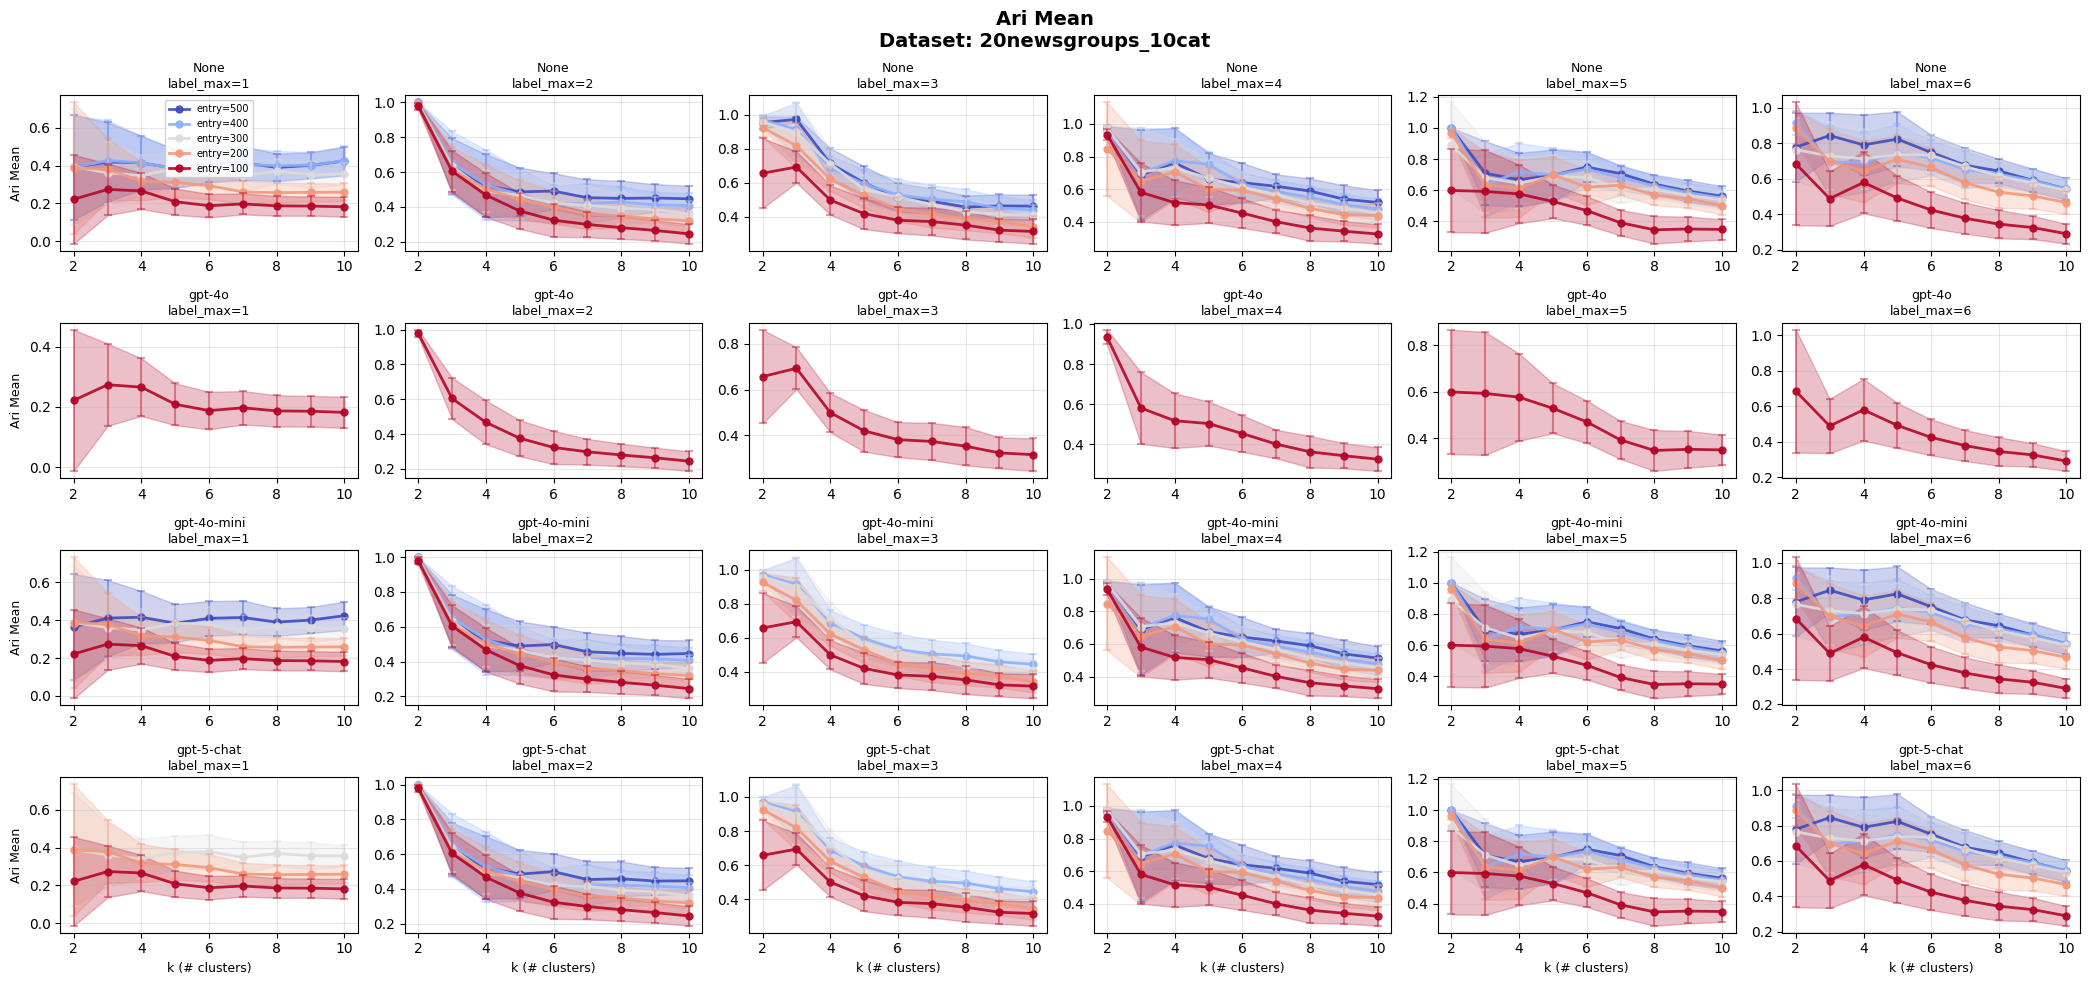

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

if not df.empty:
    # Get available options
    datasets_avail = sorted(df['dataset'].unique())
    
    # Metric options (actual clustering metrics)
    metric_options = {
        'ARI Mean': 'ari_mean',
        'Silhouette Mean': 'silhouette_mean',
        'Coverage Mean': 'coverage_mean',
        'Inertia Mean': 'inertia_mean',
        'ARI vs Ground Truth': 'ari_vs_ground_truth',
        'Objective': 'objective'
    }
    
    # Create selection widgets (no entry_max - it's now a line dimension)
    dataset_select = pn.widgets.Select(
        name='Dataset',
        options=datasets_avail,
        value=datasets_avail[0] if datasets_avail else None
    )
    
    metric_select = pn.widgets.Select(
        name='Metric',
        options=metric_options,
        value='ari_mean'
    )
    
    # Function to create the subplot grid
    @pn.depends(dataset_select, metric_select)
    def create_subplot_grid(dataset, metric):
        if dataset is None:
            return pn.pane.Markdown("**Please select dataset**")
        
        # Filter data by dataset only
        df_filtered = df[df['dataset'] == dataset]
        
        if df_filtered.empty:
            return pn.pane.Markdown(f"**No data for dataset={dataset}**")
        
        # Check if metric has data
        if metric not in df_filtered.columns or df_filtered[metric].isna().all():
            return pn.pane.Markdown(f"**Metric '{metric}' has no data for this selection**")
        
        # Get unique values for dimensions
        summarizers = sorted(df_filtered['summarizer'].unique())
        label_maxes = sorted(df_filtered['label_max'].dropna().unique())
        entry_maxes = sorted(df_filtered['entry_max'].dropna().unique(), reverse=True)  # High to low for blue→red
        
        if not summarizers or not label_maxes or not entry_maxes:
            return pn.pane.Markdown("**No data available for plotting**")
        
        # Create color map: blue (high entry_max) → red (low entry_max)
        colors = cm.coolwarm(np.linspace(0, 1, len(entry_maxes)))
        
        # Create subplot grid
        n_rows = len(summarizers)
        n_cols = len(label_maxes)
        
        fig, axes = plt.subplots(
            nrows=n_rows,
            ncols=n_cols,
            figsize=(n_cols * 3.5, n_rows * 2.5),
            squeeze=False
        )
        
        fig.suptitle(f'{metric.replace("_", " ").title()}\nDataset: {dataset}', 
                     fontsize=14, fontweight='bold')
        
        # Plot each combination
        for i, summarizer in enumerate(summarizers):
            for j, label_max in enumerate(label_maxes):
                ax = axes[i, j]
                
                # Plot a line for each entry_max
                for idx, entry_max in enumerate(entry_maxes):
                    # Get data for this specific combination
                    data = df_filtered[
                        (df_filtered['summarizer'] == summarizer) &
                        (df_filtered['label_max'] == label_max) &
                        (df_filtered['entry_max'] == entry_max)
                    ].sort_values('k')
                    
                    if not data.empty and not data[metric].isna().all():
                        color = colors[idx]
                        
                        # Plot line
                        ax.plot(data['k'], data[metric], 
                               marker='o', linewidth=2, markersize=5,
                               color=color, label=f'entry={int(entry_max)}',
                               alpha=0.9)
                        
                        # Add error bars if std is available
                        std_col = metric.replace('_mean', '_std')
                        if std_col in data.columns and not data[std_col].isna().all():
                            # Shaded region (darker)
                            ax.fill_between(
                                data['k'],
                                data[metric] - data[std_col],
                                data[metric] + data[std_col],
                                color=color,
                                alpha=0.25  # Darker than before (was 0.2)
                            )
                            
                            # Error bars on points
                            ax.errorbar(data['k'], data[metric], 
                                       yerr=data[std_col],
                                       fmt='none', ecolor=color, 
                                       alpha=0.4, capsize=3, capthick=1.5)
                
                # Styling
                ax.set_title(f"{summarizer}\nlabel_max={int(label_max)}", fontsize=9)
                ax.grid(True, alpha=0.3)
                
                # Legend on first subplot only
                if i == 0 and j == 0:
                    ax.legend(fontsize=7, loc='best', framealpha=0.9)
                
                # Labels only on edges
                if j == 0:
                    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=9)
                if i == n_rows - 1:
                    ax.set_xlabel('k (# clusters)', fontsize=9)
        
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, dpi=100)
    
    # Layout
    controls = pn.Column(
        "### Controls",
        pn.Row(dataset_select, metric_select),
        pn.pane.Markdown("**Note:** Each line represents a different entry_max value (blue=high, red=low)."),
        pn.pane.Markdown("**Shaded regions** show ±1 std, **error bars** show std at each point.")
    )
    
    pn.Column(controls, create_subplot_grid).servable()
else:
    print("[WARN] No data available")

## Batch Generate All Subplot Grids

Generate and save subplot grid images for all metric × dataset combinations:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path

if not df.empty:
    # Create output directory
    output_dir = Path("..") / "experimental_results" / "plots"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"Output directory: {output_dir.absolute()}")
    
    # Get all unique datasets and metrics
    datasets_all = sorted(df['dataset'].unique())
    
    metric_options = {
        'ari_mean': 'ARI Mean',
        'silhouette_mean': 'Silhouette Mean',
        'coverage_mean': 'Coverage Mean',
        'inertia_mean': 'Inertia Mean',
        'ari_vs_ground_truth': 'ARI vs Ground Truth',
        'objective': 'Objective'
    }
    
    # Filter to only metrics that have data
    available_metrics = {k: v for k, v in metric_options.items() 
                        if k in df.columns and not df[k].isna().all()}
    
    print(f"\nGenerating {len(datasets_all)} datasets × {len(available_metrics)} metrics = {len(datasets_all) * len(available_metrics)} plots")
    print(f"Datasets: {datasets_all}")
    print(f"Metrics: {list(available_metrics.values())}")
    print("\nGenerating plots...")
    
    # Generate all combinations
    plot_count = 0
    for dataset in datasets_all:
        for metric, metric_name in available_metrics.items():
            plot_count += 1
            
            # Filter data by dataset
            df_filtered = df[df['dataset'] == dataset]
            
            if df_filtered.empty or df_filtered[metric].isna().all():
                print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] Skipping {dataset} × {metric_name} (no data)")
                continue
            
            # Get dimensions
            summarizers = sorted(df_filtered['summarizer'].unique())
            label_maxes = sorted(df_filtered['label_max'].dropna().unique())
            entry_maxes = sorted(df_filtered['entry_max'].dropna().unique(), reverse=True)
            
            if not summarizers or not label_maxes or not entry_maxes:
                print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] Skipping {dataset} × {metric_name} (missing dimensions)")
                continue
            
            # Create color map
            colors = cm.coolwarm(np.linspace(0, 1, len(entry_maxes)))
            
            # Create subplot grid
            n_rows = len(summarizers)
            n_cols = len(label_maxes)
            
            fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(n_cols * 3.5, n_rows * 2.5),
                squeeze=False
            )
            
            fig.suptitle(f'{metric_name}\nDataset: {dataset}', 
                         fontsize=14, fontweight='bold')
            
            # Plot each combination
            for i, summarizer in enumerate(summarizers):
                for j, label_max in enumerate(label_maxes):
                    ax = axes[i, j]
                    
                    # Plot a line for each entry_max
                    for idx, entry_max in enumerate(entry_maxes):
                        data = df_filtered[
                            (df_filtered['summarizer'] == summarizer) &
                            (df_filtered['label_max'] == label_max) &
                            (df_filtered['entry_max'] == entry_max)
                        ].sort_values('k')
                        
                        if not data.empty and not data[metric].isna().all():
                            color = colors[idx]
                            
                            # Plot line
                            ax.plot(data['k'], data[metric], 
                                   marker='o', linewidth=2, markersize=5,
                                   color=color, label=f'entry={int(entry_max)}',
                                   alpha=0.9)
                            
                            # Add error bars if std is available
                            std_col = metric.replace('_mean', '_std')
                            if std_col in data.columns and not data[std_col].isna().all():
                                # Shaded region
                                ax.fill_between(
                                    data['k'],
                                    data[metric] - data[std_col],
                                    data[metric] + data[std_col],
                                    color=color,
                                    alpha=0.25
                                )
                                
                                # Error bars on points
                                ax.errorbar(data['k'], data[metric], 
                                           yerr=data[std_col],
                                           fmt='none', ecolor=color, 
                                           alpha=0.4, capsize=3, capthick=1.5)
                    
                    # Styling
                    ax.set_title(f"{summarizer}\nlabel_max={int(label_max)}", fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    # Legend on first subplot only
                    if i == 0 and j == 0:
                        ax.legend(fontsize=7, loc='best', framealpha=0.9)
                    
                    # Labels only on edges
                    if j == 0:
                        ax.set_ylabel(metric_name, fontsize=9)
                    if i == n_rows - 1:
                        ax.set_xlabel('k (# clusters)', fontsize=9)
            
            plt.tight_layout()
            
            # Save figure
            safe_dataset = dataset.replace('/', '_').replace(' ', '_')
            safe_metric = metric.replace('/', '_').replace(' ', '_')
            filename = f"{safe_dataset}_{safe_metric}.png"
            filepath = output_dir / filename
            
            fig.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] ✓ Saved: {filename}")
    
    print(f"\n✅ Done! Generated {plot_count} plots in: {output_dir.absolute()}")
    
else:
    print("[WARN] No data available")